<a href="https://colab.research.google.com/github/SHDaniels/DSPS_sDaniels/blob/main/hw5/shar_FitLineToGRBAfterGlow_mcmc_DSOS23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting a line to GRB afterglow photometry

This exercise teaches you to fit the simplest model to data: a line, using different methods.

Notes:

    a line is a power law in log-log space. The GRB afterglow is generated by a powerlaw process
    
    we will learn later that a broken powerlaw is a prefer model for the GRB afterglow. But this exercise is about fitting lines: Linear Regression
    

# initial imports

In [45]:
import pandas as pd
from matplotlib import pyplot as pl
from sklearn.linear_model import LinearRegression

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
import numpy as np

# Read in the input dataset
I am reading the data with Pandas. Pandas has excellent utilities for input-output of tabular data and also for time variables. We will use it throughout as our main package to acquire and manipulate data

In [46]:
grbAG = pd.read_csv("https://raw.githubusercontent.com/fedhere/DSPS_FBianco/main/data/grb050525A.csv")
grbAG.head()

,filter,time,mag,magerr,upperlimit
0,V,66,13.21,0.24,0
1,V,67,12.90,0.23,0
2,V,68,12.86,0.23,0
3,V,69,13.01,0.23,0
4,V,70,12.97,0.23,0


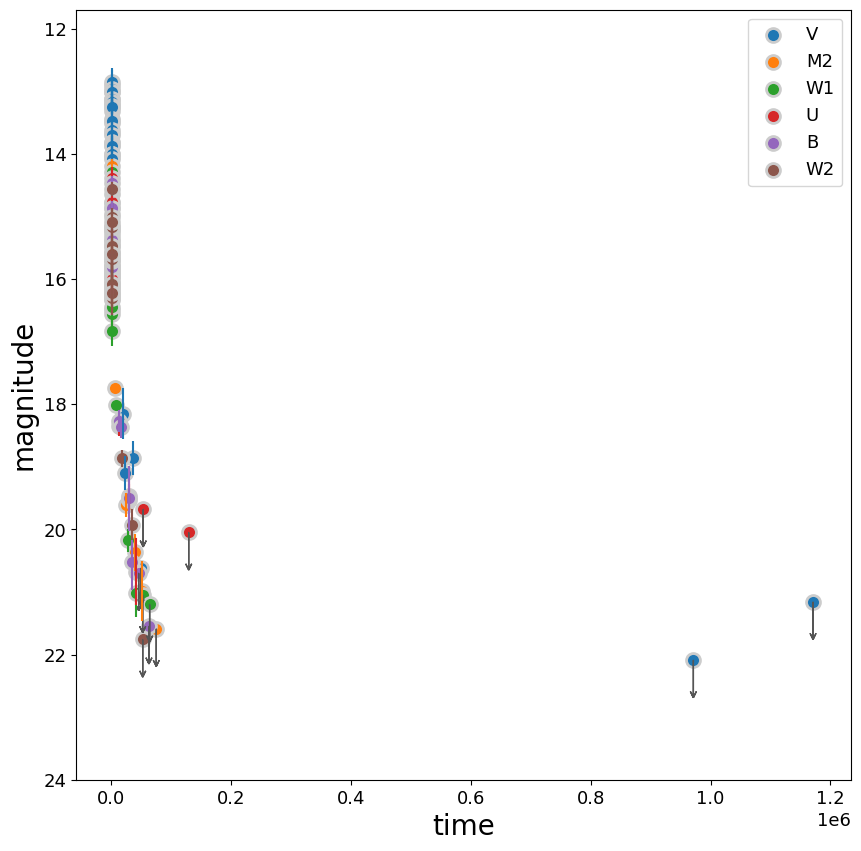

In [47]:
#create a figure container and an axis object inside of it
ax = pl.figure(figsize=(10,10)).add_subplot(111)

#loop on every filter to plot - this will give differnt colors naturally.
#Use pl.errorbar to plot the uncertainties

for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "time"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

# replot to add a better marker (optional)
for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "time"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


# plot the upperlimits as arrows
nuplim = grbAG.mag.isna().sum()
for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].time,
             grbAG.loc[i].mag, 0, 0.5, head_width=1e4,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

# I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
pl.ylim(24,11.7)
pl.legend()

#Always rememebr you axis labels!!
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("time", fontsize=20);

# Create the log-time variable

We will fit a line in log space. That corresponds to fitting a powerlaw y=x^a in natural space.


In [48]:
grbAG["logtime"] = np.log10(grbAG["time"])

In [49]:
grbAG.head()

,filter,time,mag,magerr,upperlimit,logtime
0,V,66,13.21,0.24,0,1.819544
1,V,67,12.90,0.23,0,1.826075
2,V,68,12.86,0.23,0,1.832509
3,V,69,13.01,0.23,0,1.838849
4,V,70,12.97,0.23,0,1.845098


# Visualize the data
The data are photometric measurements: measurement of flux from an exploding star. The flux is measured in different photometric bands, i.e. within different wavelength range. You can think about this as a filter that would limit the light collected by a camera to a single color, e.g. red, blue, or green. In most all cameras (your phone camera for example) collect data in RGB bands saparately and combine them to create a "color picture". Our eyes also perceive color in 3 bands, R, G, B.

The information about the photometric band is stored in the variable ```grbAG.filter```. Plot the data with different colors for different photometric bands.

In [50]:
def plotlogtime(df, models=[]):
  #create a figure container and an axis object inside of it
  ax = pl.figure(figsize=(10,10)).add_subplot(111)

  #loop on every filter to plot - this will give differnt colors naturally.
  #Use pl.errorbar to plot the uncertainties

  for f in grbAG["filter"].unique():
    pl.errorbar(grbAG.loc[grbAG["filter"] == f, "logtime"],
                grbAG.loc[grbAG["filter"] == f, "mag"],
                yerr=grbAG.loc[grbAG["filter"] == f, "magerr"],
                fmt='.', ms=0,
                fcolor=None, label=None)

  # replot to add a better marker (optional)
  for f in grbAG["filter"].unique():
    pl.scatter(grbAG.loc[grbAG["filter"] == f, "logtime"],
               grbAG.loc[grbAG["filter"] == f, "mag"],
               alpha=1, s=100, linewidth=2,
               label=f,
               edgecolor='#cccccc')


  # plot the upperlimits as arrows
  nuplim = grbAG.mag.isna().sum()
  for i in grbAG[grbAG.upperlimit == 1].index:
    pl.arrow(grbAG.loc[i].logtime,
             grbAG.loc[i].mag, 0, 0.5, head_width=0.1,
             overhang=1, shape="full",
             head_length=0.1, ec='#555555', visible=True)

  # I am going to invert the y axis because the "magnitude" measurement is an inverse scale: brighter is smaller
  pl.ylim(24,11.7)
  pl.legend()

  #Always rememebr you axis labels!!
  pl.ylabel("magnitude", fontsize=20)
  pl.xlabel("log time", fontsize=20)
  return ax

<Axes: xlabel='log time', ylabel='magnitude'>

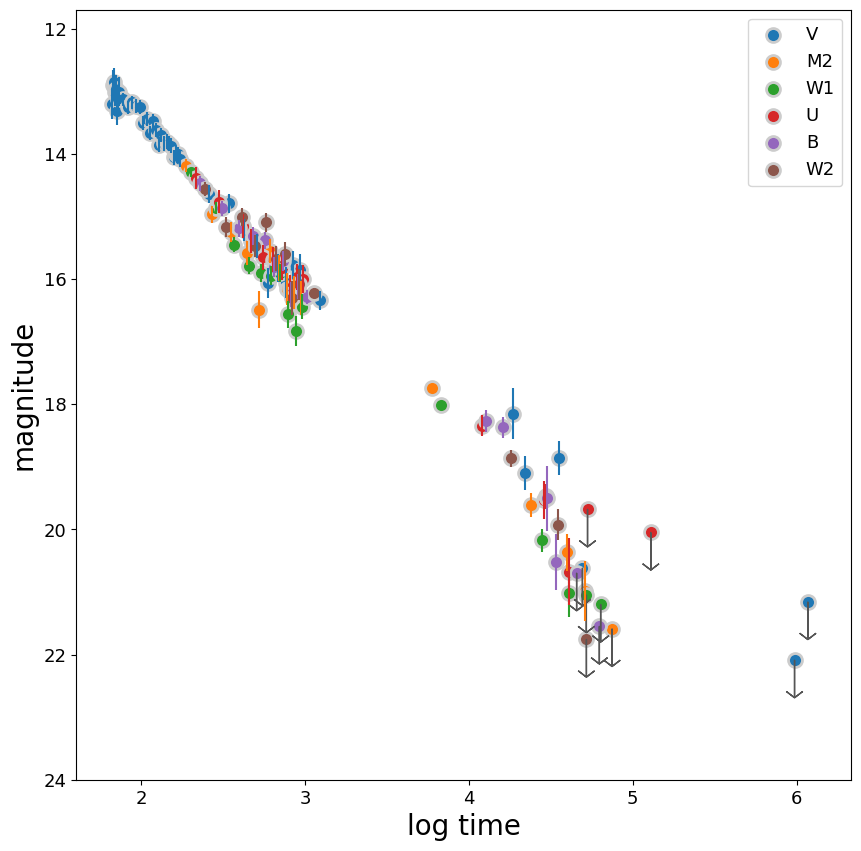

In [51]:
plotlogtime(grbAG)

Figure 1: Photometry of the Afterglow of GRB 052505A. All photometry is from the Swift satellite and it is obtained from Table 3 of Blustin et al. 2005 https://arxiv.org/pdf/astro-ph/0507515.pdf. The photometric band for each datapoint is indicated in the legend. Time is relative from the estimated moment of explosion of the stellar progenitor. Upperlimits are indicated by down-pointing arrows.

# Solve using the Normal Equation

It can be shown that the best linear fit to data is given by the equation:  

$(X^T \cdot X)^{-1} \cdot X^T \cdot \vec{y}$

The solution is a tuple of 2 parameters: sloper and intercept. Therefore the input has to be Nx2


In [52]:
x = grbAG[grbAG.upperlimit == 0].logtime.values
X = np.c_[np.ones((len(grbAG) - grbAG.upperlimit.sum(), 1)),
          x]


y = grbAG.loc[grbAG.upperlimit == 0].mag.values
print("shape of the input array X", X.shape)
print("shape of the input array y", y.shape)
#note the shape in python is flipped compared to the shape in linear algebra

shape of the input array X (108, 2)
shape of the input array y (108,)


In [53]:
theta_best = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
print ("best fit parameters from the Normal Equation: " +
       "intercept {:.2f}, slope {:.2f}".format(*theta_best))

best fit parameters from the Normal Equation: intercept 8.58, slope 2.51


# Fit a line to the data (excluding the upper limits) with sklearn LinearRegression

The exogenous (independent) variable is ```grbAG.logtime```.

The information about whether the point is an upper limit or a measurement is stored in the variable ```grbAG.upperlimit```.
To remove the upper limits you can "broadcast" the data: in pandas that looks like

```grbAG.loc[grbAG.upperlimit == 0]```



In [54]:
grbAG = grbAG[grbAG.upperlimit==0]
grbAG.tail()

,filter,time,mag,magerr,upperlimit,logtime
103,V,35638,18.860000,0.27,0,4.551913
104,M2,39683,20.369034,0.30,0,4.598604
105,W1,40585,21.017147,0.39,0,4.608366
106,U,41040,20.674538,0.54,0,4.613207
109,M2,51257,20.989034,0.48,0,4.709753


In [55]:
#note: imports should be moved to the top cell - follow PEP8 guidelines

lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [56]:
lr.intercept_

8.582668233648771

In [57]:
lr.coef_

array([0.        , 2.51199984])

In [58]:
print ("best fit parameters from sklearn linear regression: " +
       "intercept {:.2f}, slope {:.2f}".format(lr.intercept_, lr.coef_[1]))

best fit parameters from sklearn linear regression: intercept 8.58, slope 2.51


same as from the normal equation!

# Fit a line to the data (excluding the upper limits) by minimizing an objective function

First, choose the L1 and L2 metric (see class notes) as the objective function.

Use ```scipy.optimize.minimize()``` to minimize it.


In [59]:
def line(intercept, slope, x):
    return intercept+ slope*x

In [60]:
def l1(args, x, y):
    '''l1 target function: returns value of l1 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L1 sum of difference between prediction and data
    '''
    intercept, slope = args
    return sum(np.abs(y-line(intercept, slope, x)))


initialGuess = (2,2)

l1Solution = minimize(l1, initialGuess, args=(x, y))
print(l1Solution)
print("")
print("best fit parameters from the minimization of L1: " +
       "slope {:.2f}, intercept {:.2f}".format(*l1Solution.x))

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 26.30740226653668
        x: [ 8.230e+00  2.639e+00]
      nit: 8
      jac: [ 0.000e+00 -1.958e+00]
 hess_inv: [[ 6.392e-02 -2.800e-02]
            [-2.800e-02  1.262e-02]]
     nfev: 157
     njev: 51

best fit parameters from the minimization of L1: slope 8.23, intercept 2.64


In [61]:

def l2(args, x, y):
    '''l2 target function: returns value of l2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    returns L2 sum of difference between prediction and data squared
    '''
    intercept, slope = args
    return sum((np.abs(y-line(intercept, slope, x)))**2)

initialGuess = (2,2)

l2Solution = minimize(l2, initialGuess, args=(x, y))
print(l2Solution)
print("")
print("best fit parameters from the minimization of L2: " +
       "slope {:.2f}, intercept {:.2f}".format(*l2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 12.825987500725512
        x: [ 8.583e+00  2.512e+00]
      nit: 5
      jac: [ 1.192e-07 -1.192e-07]
 hess_inv: [[ 6.254e-02 -2.030e-02]
            [-2.030e-02  7.114e-03]]
     nfev: 21
     njev: 7

best fit parameters from the minimization of L2: slope 8.58, intercept 2.51



# Fit a line to the data (excluding the upper limits) by minimizing an objective function that accounts for the measurements uncertainties

Since the data has uncertainty, choose the $\chi^2$ (chi squared) function as your objective function.

In [62]:
def chi2(args, x, y, s):
    '''chi^2 target function: returns value of chi^2 for given arguments and data for a line model
    arg: (array) model arguments (parameters)
    x: the exogenous variable (array)
    y: the exogenous variable (array)
    s: the error
    returns chi^2 sum of difference between prediction and data squared
    '''
    intercept, slope = args
    return sum(((np.abs(y-line(intercept, slope, x)))**2)/s)

x = grbAG[grbAG.upperlimit == 0].logtime.values
y = grbAG.loc[grbAG.upperlimit == 0].mag.values
s = grbAG.loc[grbAG.upperlimit == 0].magerr.values

initialGuess = (2,2)

chi2Solution = minimize(chi2, initialGuess, args=(x, y, s))
print(chi2Solution)
print("")
print("best fit parameters from the minimization of the chi squared: " +
       "slope {:.2f}, intercept {:.2f}".format(*chi2Solution.x))

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 58.49837428948359
        x: [ 8.582e+00  2.500e+00]
      nit: 6
      jac: [-2.861e-06  3.338e-06]
 hess_inv: [[ 1.113e-02 -3.813e-03]
            [-3.813e-03  1.398e-03]]
     nfev: 24
     njev: 8

best fit parameters from the minimization of the chi squared: slope 8.58, intercept 2.50


# Plot all the solutions

Create a function that uses the parameters you input and plots a line. Add a legend that describes which line corresponds to what.


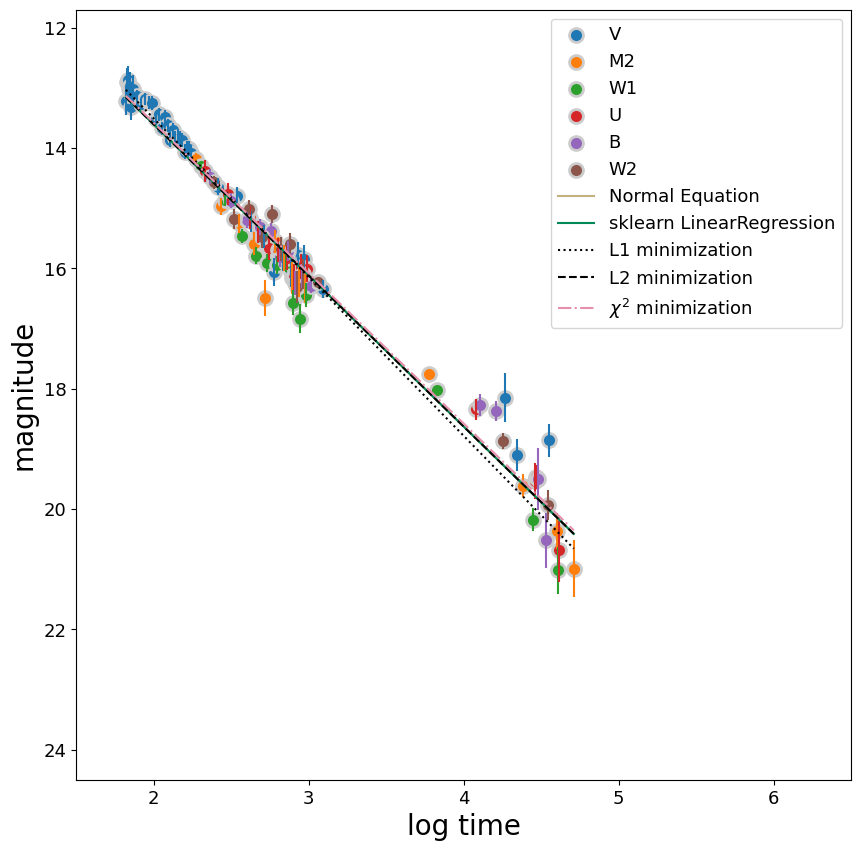

In [63]:
def plotline(pars, x, color='k', symbol='-', label='model',
             alpha=1, ax=ax):
    slope, intercept = pars
    y = line(intercept, slope, x)
    ax.plot(x, y, ls=symbol, c=color, label=label, alpha=alpha)


ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],
         label="Normal Equation", ax=ax)

#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)

#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':',
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--',
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.',
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')

pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);


Figure 2: Same as Figure 1, but with linear regression models plotted. The models correspond to the best fit line to the data (excluding upper limits) calculated analytically by solving the normal equation, by solving the fit analysitcally with sklearn.LinearRegression(), and by minimizing the objective functions L1, L2, and Chi squared. The models are indicated in the legend.

# HW part 1: redo the sklearn model with a train-test split of the data

- choose the train-test rations that you prefer
- get the score for the model when predicting on the train data and on the test data
- what can you say about the model by comparing the two scores?

In [64]:
x_train, x_test, y_train, y_test  = train_test_split(
     X, y, test_size=0.3, random_state=4)

In [65]:
lr2 = LinearRegression()

In [66]:
lr2.fit(x_train, y_train)

LinearRegression()

In [67]:
lr2.score(x_train, y_train)

0.9766485812679301

In [68]:
lr2.score(x_test, y_test)

0.9535515152089498

In [69]:
print ("best fit parameters from sklearn linear regression on training data: " +
       "intercept {:.2f}, slope {:.2f}".format(lr2.intercept_, lr2.coef_[1]))

best fit parameters from sklearn linear regression on training data: intercept 8.49, slope 2.55


The model performs slightly better on the training data than the testing data (as expected), but it is still a very good fit.

# Now try a line to the data with MCMC

# HW part 2: write captions for each figure. The figures are produced by my code. The captions should state:
- what is plotted
- what is noticeable or interesting in the figure



In [70]:
!pip install emcee # install the emcee package that implements the _affine invariant MCMC_ method

In [71]:
import emcee #import the package

In [72]:
emcee

<module 'emcee' from '/usr/local/lib/python3.10/dist-packages/emcee/__init__.py'>

look at documentation: https://emcee.readthedocs.io/en/stable/

We are implementing Bayes theorem to find the best model parameters: $P(\theta | D) ~ P(D | \theta) * P(\theta)$ or _Posterior ~ Likelihood * Prior_

Since we are maximizing the likelihood, we work in log space because:
- the logarithm is a monotonic function of its argument (meaning where the argument gets bigger its log gets bigger, where it gets smaller its log gets smaller)
- the log is not defined for negative values (log(something < 0) is undefined) but this does not matter because the likelihood is a probability and probabilities are positive defined.



In [73]:
# LINE MODEL
def log_prior(theta):
  slope, intercept = theta
  if slope > 0 and intercept > 0:
    return 0
  #semi informative prior: i know light has to get fainter (mag get bigger)
  #i know i dont use negative mags
  return -np.inf


In [74]:
#log likelihood
def log_likelihood(theta, x, y, yerr):
  slope, intercept = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return -np.sum(((y - line(intercept, slope, x))**2) / yerr**2)

In [75]:
#log posterior
def log_posterior(theta, x, y, yerr):
  lp = log_prior(theta)
  if not np.isfinite(lp):
    return -np.inf
  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp + log_likelihood(theta, x, y, yerr)

In [76]:
#initial guess
ig = [1,10]

In [77]:
#initialize N walkers
nwalkers = 32
ndim = len(ig)

In [78]:
pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

In [79]:
pos.shape

(32, 2)

In [80]:
# this sets up the model and assignes the hyperparameters
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x, y, s))

In [81]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:08<00:00, 559.86it/s]


In [82]:
# this extracts the ergodic markovian chains of positions in the feature space
samples = sampler.get_chain()

In [83]:
samples.shape

(5000, 32, 2)

In [84]:
# to get statistical properties of the chains I will concatenate the 32 chains. This works _iff_ the chains are independent
# note: the chains are _assumed_ to be independent
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)

In [85]:
#the result of the mcmc (the best parameters and their uncertainties) are statistical properties of the chains
# I recommand the median and percentiles over the mean and standard deviation, since the chains need not be gaussian
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
  mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc

array([[2.46601682, 2.48025458, 2.49441722],
       [8.55964404, 8.59919063, 8.63928018]])

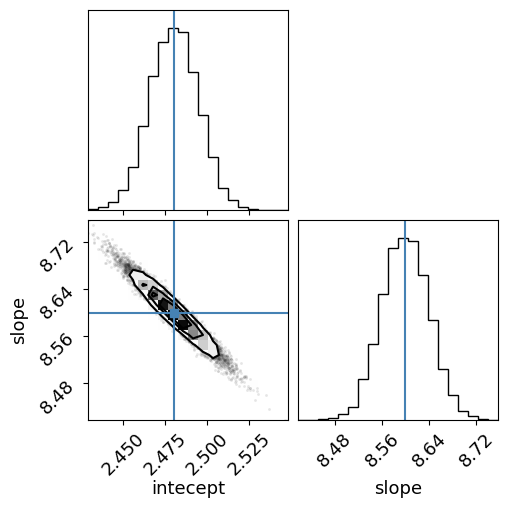

In [86]:
#plotting the likelihood space: the panels are 2D projections of the feature space and 1D marginalized probabilities for each parameters
!pip install corner
import corner
pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["intecept", "slope"], truths=mcmc[:,1]);


Figure 3. Here we have a corner plot of the two parameters that our MCMC sampled. On the diagonals, we can see the variance of the intercept with itself (top left) and the slope with itself (bottom right), and we can see a clear maximum for each and a nice smooth distribution surrounding it (we would get worried if it looked un-gaussian). On the bottom left, we can see the covariance of the slope and intercept. We can see that they are strongly correlated, so changing one has an effect on the fit of the other. The contour lines and points show us the areas where the walkers spent more time, which correspond to more favored regions of parameter space. The best parameters in all plots are marked with a blue line.

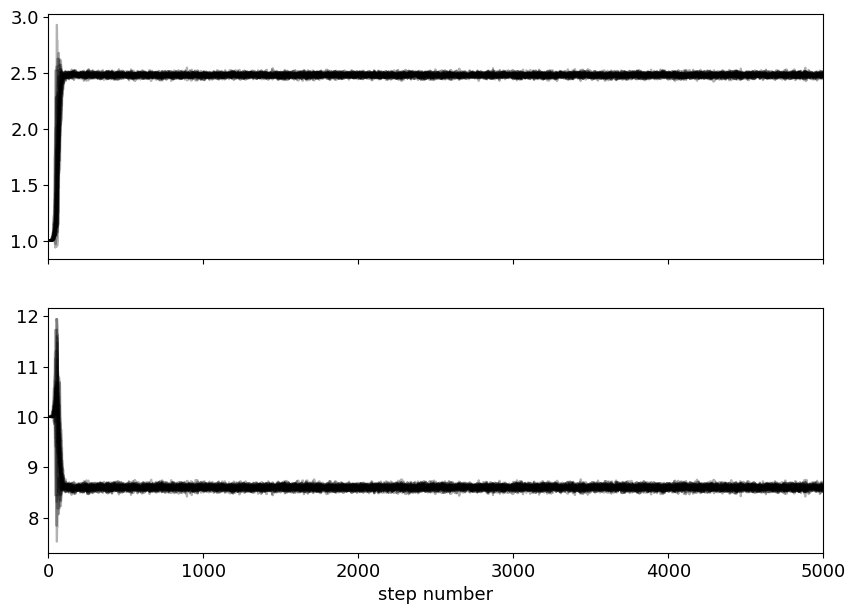

In [88]:
# the chains should be plotted as well. in the slides and in class I discuss what you should expect them to look like
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 4. This is an overview of the MCMC chains, plotted by step number. The top plot is the slope parameter, and the bottom plot is the intercept parameter. Each of them vary wildly up until step ~100 and then converge and stay in the same region of parameter space. This long stretch of little variation makes us happy that our walkers have ended up in a good region of parameter space. Generally, when you're using mcmc chains to calculate the preferred values of your parameters, you don't include the first steps before the walkers settle in.

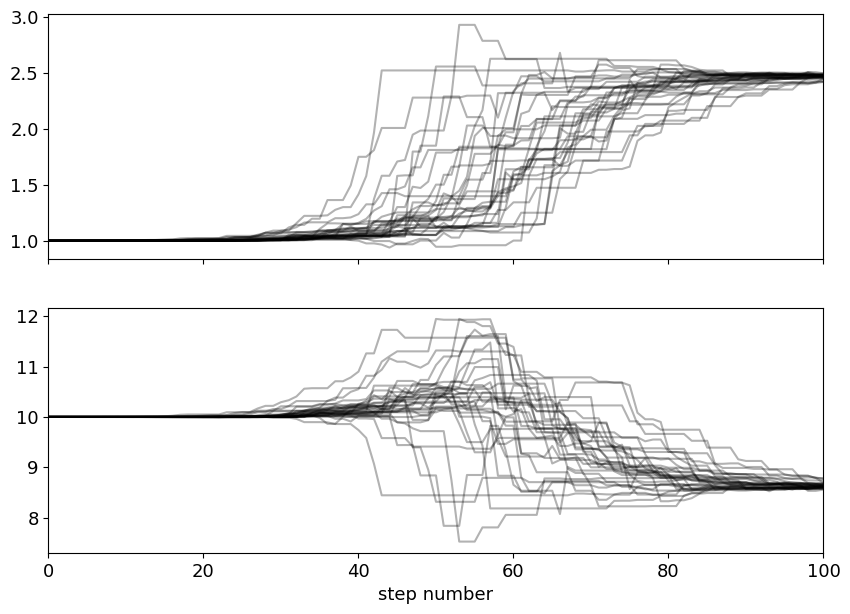

In [89]:
# zoom in: the beginnign of the chane should be cut - this is the burn-in part of the chain
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 100)#len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Figure 5. This is a zoomed in version of figure 4, only showing the first 100 steps of the chain. The top is still slope, botton is still intercept. At the beginning, most steps in parameter space are not accepted, because the walkers haven't found a good direction to step yet. Then, eventually they do, and they explore until they settle down. We can see that each of the walkers takes a different path to get to the same final region of parameter space. It's a stochastic process!

In [90]:
# save the mcmc results for later
mcmc_line = mcmc

# HW part 3

# Now try a broken power law (BPL) model

A power la is not a good model for GRB afterglows. A broken power law has been known to be a better model and has several physical motivations. In this exercise you will fit a _broke power law_ to the data, which is a more complex and higher dimensional model than the simple line fit we did so far, with MCMC getting best values for the posterior, a complete characterization of the likelihood, and allowing model selection between the line and the power law.

> Here is some info that talks about the power law model and the phsyics of GRB, which you need not know to solve the assignment but you may be interested in.  A broken power law is a power law ($y ~ x^a$) where the power a changes at some point. This can be caused by the presence of two power law processes with different, for example, where one dominates at early time and the other at late times.


>> Here is some more info that explains why we observed the GRB afterglows as broken power laws.
>>Gamma-ray bursts (GRBs) are produced by the collapse of massive stars or the merger of compact objects like neutron stars. The energy of the collapse is highly energetic (Gamma rays) but the emission gets reprocessed as it leaves the system and looses energy becoming detectable in the optical wavelengths. This is called the "optical afterglow of the GRB".
>>The explosion resulting from the collapse generates a highly relativistic outflow of material that moves at a significant fraction of the speed of light.
>> The afterglow emission is primarily produced through synchrotron radiation, where charged particles spiral around magnetic field lines. The radiation produced by synchrotrone follows a power law with an index that depends on the density of the surrounding medium, the Lorentz factor of the outflow, and the magnetic field strength. As the radiation crosses different regions of the system that collapsed these factors change and the powerlaw index changes with them.

>>If the relativistic outflow is highly collimated (a jet) as the jet expands, its emission can be modeled as a power-law light curve, but  where the jet begins to decelerate and spread out the slope of the power law changes. This transition is known as the "jet break" and results in a broken power-law behavior.

>> Some GRBs exhibit late-time flares or additional energy injection from the central engine but we are not modeling this in this exercise.




_BPL model variables:_

$F = \mathrm{flux}$ - note: not magnitude this time! $mag ~ -2.5log10(Flux)$

$t =  \mathrm{time}$ - note: not log time

_BPL model parameters:_


$T_b =  \mathrm{Time~of~break}$

$a_1:  \mathrm{Early~slope}$

$a_2: \mathrm{Late~slope}$

$b:  \mathrm{nuisance~parameters}$

_BPL model_:

$F=\frac{F_0}{ \frac{t}{T_b}^{-a1} + \frac{t}{T_b}^{-a2}}$


mag = $b - log_{10}((\frac{t}{T_b})^{-a1} + (\frac{t}{T_b})^{-a2}) $



In [91]:
t = grbAG[grbAG.upperlimit == 0].time.values

In [92]:
t.min(), t.max()

(66, 51257)

# HW part 3 task 1:
create the model `bpl()`, the `log_likelihood()`, `log_prior()` (choose what you want to set your prior to), and `log_posterior()`

In [93]:
!pip install icecream
from icecream import ic

In [94]:
def bpl (theta, t):
    """broken power law model
    Input:
      theta: (array like) 4 parameters vector, see equation
      x: (array like) independent variable - probably time
    Return:
      model predictions for each x (array like)
    """
    Tb, a1, a2, b = theta
    mag = b - np.log10(((t/Tb)**(-a1))+((t/Tb)**(-a2)))

    return mag


In [95]:
def log_likelihood_bpl(theta, t, y, yerr):
  # use the same log_likelihood as before (chi2) but with the new model
  Tb, a1, a2, b = theta
  #chi2 likelihood : (data-model)**2 / uncertainty **2
  return np.sum(((y - bpl(theta, t))**2) / yerr**2)


def log_prior_bpl(theta):
  Tb, a1, a2, b = theta

  if (Tb > 0) and (a1 > 0) and (a2 > 0):
    return 0
  else:
    return -np.inf


#log posterior
def log_posterior_bpl(theta, t, y, yerr):
  lp = log_prior_bpl(theta)

  if not np.isfinite(lp):
    return -np.inf

  # posterior ~ likelihood * prior => log_posterior ~ log_likelihood + log_prior
  return lp - log_likelihood_bpl(theta, t, y, yerr)

# HW part 3 task 2:
Find the initial starting point as a stochastic gradient descent minimization of the log likelihood

In [96]:

#ig = [0.2, 5, 1000, 20]
ig = [1000, 5, 20, 0.2]
#what does the minimize function need to take as arguments?
soln = minimize(log_likelihood_bpl, ig, args=(t, y, s))
soln

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 217.46531456855303
        x: [ 2.736e+02  3.548e+00  2.146e+00  1.505e+01]
      nit: 79
      jac: [ 1.526e-05 -3.624e-05 -3.052e-05  4.005e-05]
 hess_inv: [[ 1.477e-03 -2.157e-03  5.454e-04 -2.955e-04]
            [-2.157e-03  3.228e-03 -8.951e-04  4.756e-04]
            [ 5.454e-04 -8.951e-04  3.279e-04 -1.552e-04]
            [-2.955e-04  4.756e-04 -1.552e-04  1.728e-04]]
     nfev: 699
     njev: 138

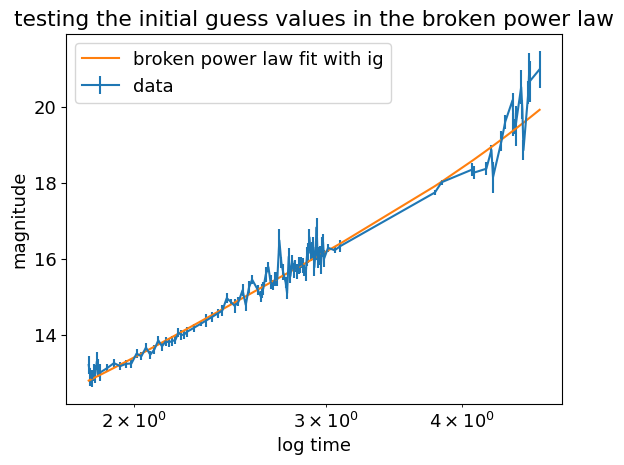

In [116]:
ig = soln.x # the initial guess for the MCMC

# plot the model as it looks with the initial guess values
pl.errorbar(x, y, yerr=s)
pl.plot(x, bpl(ig, t))
pl.xscale("log")

pl.xlabel("log time")
pl.ylabel("magnitude")
pl.title("testing the initial guess values in the broken power law")
pl.legend([ "broken power law fit with ig", "data"])
pl.show()

Figure. This is a diagnostic plot to look at the solution that we found from minimizing the log likelihood for the broken power law with sklearn. We are using it as the starting point for our mcmc. The fit looks to be pretty reasonable.

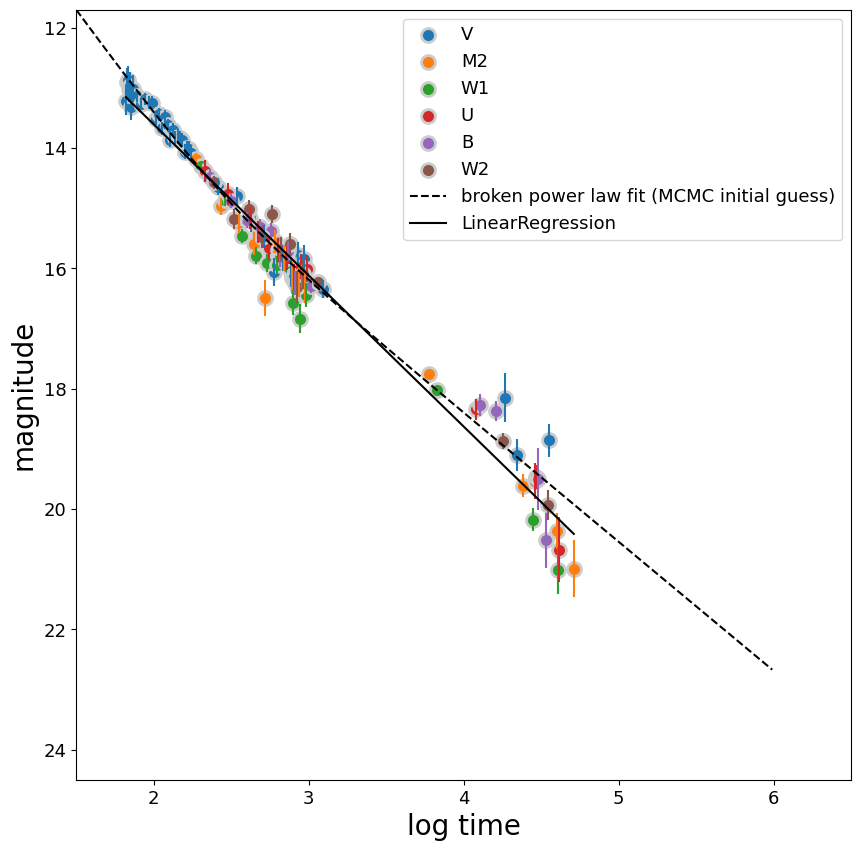

In [98]:
labels = ["intercept","slope"]
ax = plotlogtime(grbAG)
#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(np.arange(1.5,6,0.01),
        bpl(ig, 10**np.arange(1.5,6,0.01)), ls="--", c="k",
        label="broken power law fit (MCMC initial guess)")



#with the LinearRegression object I can also do
pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-',
        label="LinearRegression")
pl.legend()
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);

Figure. Here we can see the prettier version of the last plot. THe broken power law fit diverges from the linear regression fit towards larger times (and to a lesser extend at earlier times), and seems to be a slightly better overall fit than the linear regression line.

# HW 3 task 3: optimize the model wit MCMC

- set the emcee hyperparameters
- run the chains
- extract the statistical properties of the chain as the best fit values
- plot the model
- plot the marginalized posteriors of the model parameters

In [100]:
# set the emcee hyperparameters
#initialize N walkers
nwalkers = 32
ndim = len(ig)

pos = np.array(ig) + 1e-4 * np.random.randn(nwalkers, ndim) #the starting point for each walker is a small perturbation of the initial guess

# pos = np.array(ig) + 1e-2 * np.abs(np.random.multivariate_normal(ig, cov=np.eye(ndim), size=nwalkers))


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_bpl, args=(t, y, s))

In [101]:
pos.shape

(32, 4)

In [102]:
ig

array([273.5904614 ,   3.54796095,   2.1456929 ,  15.04718588])

In [103]:
# this runs the MCMC for 5,000 steps
sampler.run_mcmc(pos, 5000, progress=True);

100%|██████████| 5000/5000 [00:06<00:00, 718.62it/s]


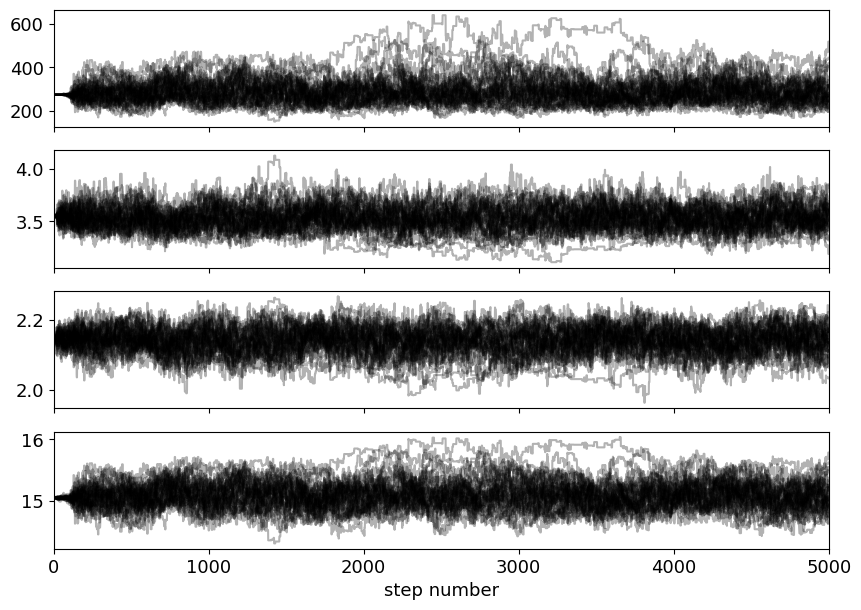

In [105]:
#plot the chains
fig, axes = pl.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)

#axes[-1].set_xlabel("step number");
axes[-1].set_xlabel("step number");

Figure. Here are the chains where the walkers have explored our four parameters, from top to bottom: Tb, a1, a2, and b. The chains do not converge but that is fine, the walkers are exploring the parameter space and the corner plot will show us what it looks like for them.

In [106]:
# get the 16th, 50, and 84th percentiles of the model parameters
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
mcmc = np.zeros((ndim, 3))
for i in range(ndim):
    mcmc[i] = np.percentile( flat_samples[:,i], [16, 50, 84])
mcmc[:,1]

array([279.63863084,   3.53240503,   2.14236135,  15.07294908])

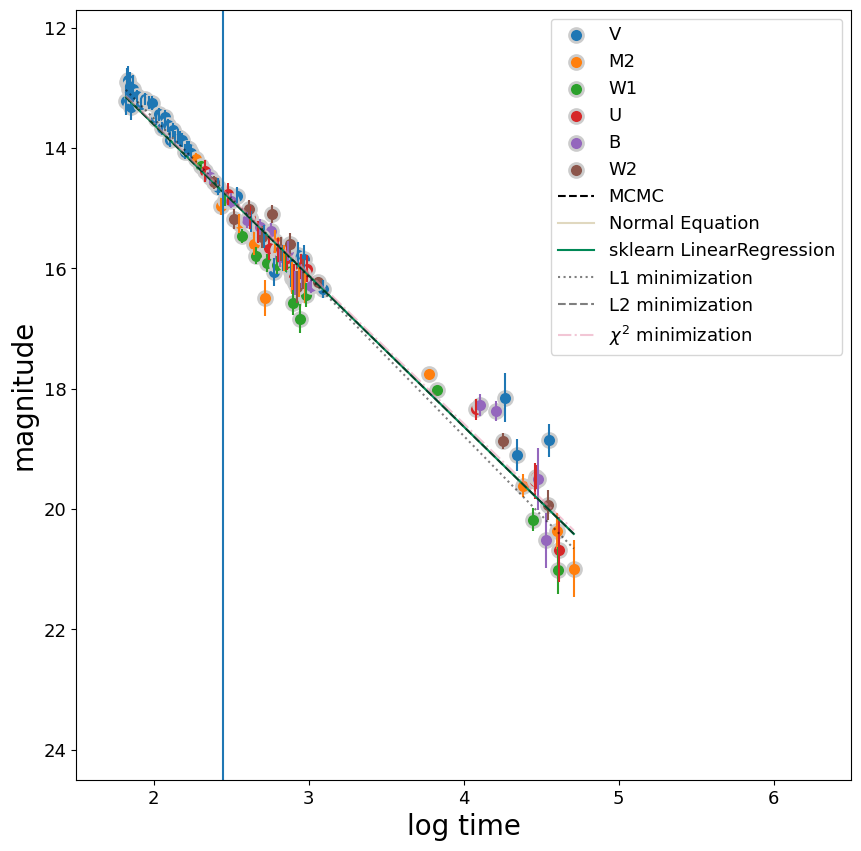

In [121]:
#plot the model
ax = plotlogtime(grbAG)

#plotting models
#use Kelley colors for maximum readability
#https://gist.github.com/ollieglass/f6ddd781eeae1d24e391265432297538
colors = ['C2B280', '848482', '008856', 'E68FAC', '0067A5', 'F99379',
          '604E97', 'F6A600', 'B3446C',
          'DCD300', '882D17', '8DB600', '654522', 'E25822', '2B3D26',
          '222222', 'F3C300', '875692', 'F38400', 'A1CAF1', 'BE0032', ]

ax.plot(grbAG.logtime.values, line(mcmc[:,1][0], mcmc[:,1][1],
                            grbAG.logtime.values), ls="--", c="k", label="MCMC")
#normal equation
plotline((theta_best[::-1]), grbAG.logtime.values,
         color='#'+colors[0],  alpha=0.5,
         label="Normal Equation", ax=ax)
#sklearn
plotline((lr.coef_[1], lr.intercept_), grbAG.logtime,
         color='#'+colors[2], symbol='-',
         label="sklearn LinearRegression", ax=ax)
#minimize L1
plotline((l1Solution.x[::-1]), grbAG.logtime,
         symbol=':', alpha=0.5,
         label="L1 minimization", ax=ax)
#minimize L2
plotline((l2Solution.x[::-1]), grbAG.logtime,
         symbol='--', alpha=0.5,
         label="L2 minimization", ax=ax)
#minimize chi2
plotline((chi2Solution.x[::-1]), grbAG.logtime,
         color='#'+colors[3], symbol='-.', alpha=0.5,
         label=r"$\chi^2$ minimization", ax=ax)

pl.legend()

#with the LinearRegression object I can also do
#pl.plot(grbAG.logtime, lr.predict(np.c_[np.ones((len(grbAG), 1)), grbAG.logtime]), 'k-')
pl.axvline(np.log10(mcmc[0,1]))
pl.ylim(24.5,11.7)
pl.xlim(1.5, 6.5)
pl.ylabel("magnitude", fontsize=20)
pl.xlabel("log time", fontsize=20);
pl.show()

Figure. Here's the same figure we've seen a bunch of times, now with the broken power law fit from the MCMC and we can see where the break occurs with the vertical line.

279.63863083794547

## plot the marginalized posterior distributions of the parameters

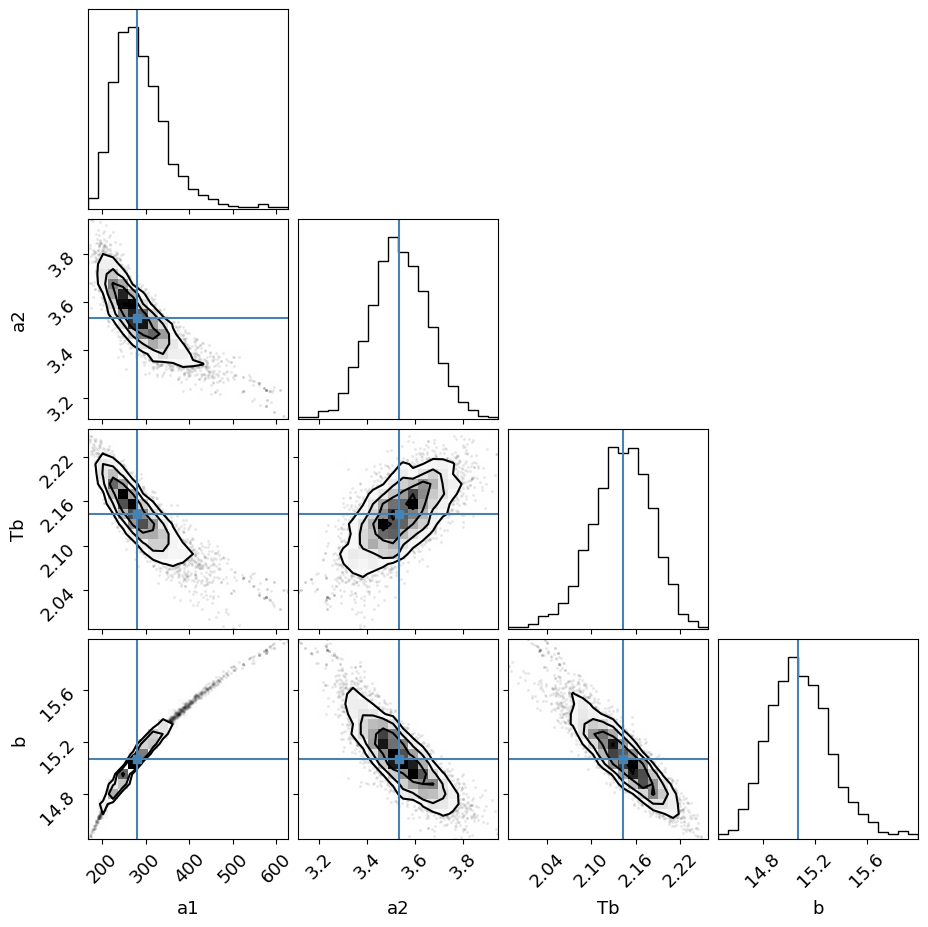

In [113]:

pl.rcParams["font.size"]= 13
fig = corner.corner(
    flat_samples, labels=["a1", "a2", "Tb", "b"], truths=mcmc[:,1]);



Figure. Here is a lovely corner plot. Each of our parameters combine to make each of the contour plots - you can see how they vary with each other, and the most notable feature is that a1 and b are strongly correlated. The diagonal shows the variance of each parameter. a1 has a fun tail (not very gaussian). but all the shapes look fine, our mcmc worked.

# HW part 4: Compare the line (as obtained by the MCMC) and broken power law models. For this part of the assignment use the slides in part 2.2 of the current slide deck (slide column 8) https://slides.com/federicabianco/dsps_6#/8. in particular:

- Print the loglikelihood of each model (you can use the log_likelihood function you had written for each)
https://slides.com/federicabianco/dsps_6#/8/1 through https://slides.com/federicabianco/dsps_6#/8/3

- implement the caluculation of the AIC (https://slides.com/federicabianco/dsps_6#/8/4 through 6)
- and BIC (https://slides.com/federicabianco/dsps_6#/8/7)



In [124]:
log_likelihood(mcmc_line[:,1], x, y, s)

-317.42076102908857

In [132]:
print("this is the log likelihood of the nonbroken: {:.3f}".format(np.abs(log_likelihood(mcmc_line[:,1], x, y, s)))) #control the decimal digits!

this is the log likelihood of the nonbroken: 317.421


In [131]:
print("this is the log likelihood of the bpl: {:.3f}".format(log_likelihood_bpl(mcmc[:,1], t, y, s)))

this is the log likelihood of the bpl: 217.474


In [140]:
ll_nonbroken = np.abs(log_likelihood(mcmc_line[:,1], x, y, s))
ll_broken = log_likelihood_bpl(mcmc[:,1], t, y, s)

## Implement the likelihood ration test printing out the likelihood ration statistics

The likelihood-ratio test assesses the goodness of fit of two competing _nested_ statistical models based on the values of the likelihood $L$ where $M1$ is the restricted model (the parameter space is smaller, hence restricted), nested inside $M2$, the full model (the more complex one).

$ \lambda_\mathrm{LR}=-2\ln {\frac {L(M1(\theta_\mathrm{restricted}))}{L(M2(\theta_\mathrm{full}))}}$

This statistics is expexted to be $\chi2$ distributed following a $ch2$ distribution with d.o.f=difference in size of the parameter space in the two models (number of parameters in bpl model - number of parameters in line model).


In [142]:
from scipy.stats.distributions import chi2
def likelihood_ratio(llmin, llmax):
    '''
    have to take the natural log
    '''
    return(-2*np.log(llmax/llmin))




In [144]:
LR = likelihood_ratio(ll_nonbroken, ll_broken)
LR

0.7562980347694678

In [145]:
chi2.sf?

In [143]:
p = chi2.sf(LR, 2)
# dof: difference in number of parameters
print ('p: %.30f' % p)
# LR is chi squared distributed:
# p represents the probability that this result
# (or a more extreme result than this)
# would happen by chance

p: 0.685128397016519619100449745019


The null hypothesis (that the simple model is better) cannot be rejected based on this p-value.

In [ ]:
# def like_ratio_statistics(...):
#   return ...

## Calculate the AIC and BIC: Aikiki Information Criterion and Bayesian Information Criterion for the comparison of the same two models.


In [151]:
len(np.shape(x))

1

In [165]:
def aic(x, L, k):
  '''
  L is the likelihood, k is the number of parameters, N is the # variables
  '''
  N = len(np.shape(x))
  return (-2/N)*np.log10(np.abs(L))+(2/N)*k
  #should shrink for better models


def bic(x, L, k):
  '''
  L is the likelihood, k is the number of parameters, N is the # variables
  '''
  N = len(np.shape(x))
  return -2*np.log10(np.abs(L))+np.log10(N)*k


In [167]:
print("AIC line {0:.2f} - AIC bpl {1:.2f}".format(aic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      aic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

print("BIC line {0:.2f} - BIC bpl {1:.2f}".format(bic(x, log_likelihood(mcmc_line[:,1], x, y, s), 2),
                                      bic(x, log_likelihood_bpl(mcmc[:,1], t, y, s), 4)))

AIC line -1.00 - AIC bpl 3.33
BIC line -5.00 - BIC bpl -4.67


It looks like the line is better for both criteria! The broken power law fit introduces unnecessary complexity to the model, which is penalized in our criteria.

# Extra Credit
 redefine the chi2 that I have written above to take a n deg polynomial, fit it to the data, compare it to the BPL model